In [98]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime
import time
import os
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import statsmodels.api as sm
from functools import reduce

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")



In [2]:
df_income = pd.read_csv('../data/income_statement.csv')
df_balance = pd.read_csv('../data/balance_sheet.csv')
df_cash_flow = pd.read_csv('../data/cash_flow_statement.csv')   
df_earnings = pd.read_csv('../data/earnings.csv')   
df_overview = pd.read_csv('../data/company_overview.csv')

In [3]:
df_technical = pd.read_csv('../data/technical_data.csv')

In [4]:
df_price = pd.read_csv('../data/tech_stock_daily_price.csv')

In [5]:
df_sentiment = pd.read_csv('../data/daily_sentiment_score.csv')

In [6]:
df_income['fiscalDateEnding'] = pd.to_datetime(df_income['fiscalDateEnding'])
df_balance['fiscalDateEnding'] = pd.to_datetime(df_balance['fiscalDateEnding'])
df_cash_flow['fiscalDateEnding'] = pd.to_datetime(df_cash_flow['fiscalDateEnding'])
df_earnings['fiscalDateEnding'] = pd.to_datetime(df_earnings['fiscalDateEnding'])
df_technical['date'] = pd.to_datetime(df_technical['date'])
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])


In [7]:
start_date = '2023-12-29'
end_date = '2025-06-29'

In [8]:
df_income = df_income[df_income['fiscalDateEnding'] >= start_date]
df_balance = df_balance[df_balance['fiscalDateEnding'] >= start_date]
df_cash_flow = df_cash_flow[df_cash_flow['fiscalDateEnding']>= start_date]

df_earnings = df_earnings[df_earnings['fiscalDateEnding'] >= start_date]
df_technical = df_technical[(df_technical['date']>=start_date) & (df_technical['date'] < end_date)]
df_price = df_price[(df_price['Date'] >= start_date)&(df_price['Date'] <end_date)]
df_sentiment = df_sentiment[(df_sentiment['date'] >= start_date)&(df_sentiment['date'] < end_date)]

In [9]:
print(df_technical['date'].min())
print(df_price['Date'].min())
print(df_sentiment['date'].min())
print(df_earnings['fiscalDateEnding'].min())
print(df_income['fiscalDateEnding'].min())
print(df_balance['fiscalDateEnding'].min())
print(df_cash_flow['fiscalDateEnding'].min())

2023-12-29 00:00:00
2023-12-29 00:00:00
2024-01-01 00:00:00
2023-12-31 00:00:00
2023-12-31 00:00:00
2023-12-31 00:00:00
2023-12-31 00:00:00


In [10]:
df_income = df_income.sort_values(by=['symbol', 'fiscalDateEnding'])
df_balance = df_balance.sort_values(by=['symbol', 'fiscalDateEnding'])
df_cash_flow = df_cash_flow.sort_values(by=['symbol', 'fiscalDateEnding'])
df_earnings = df_earnings.sort_values(by=['symbol', 'fiscalDateEnding'])
df_technical = df_technical.sort_values(by=['ticker', 'date'])
df_price = df_price.sort_values(by=['ticker', 'Date'])
df_sentiment = df_sentiment.sort_values(by=['ticker', 'date'])

In [11]:
symbol='AAPL'

In [12]:

income_data = df_income[df_income['symbol'] == symbol]
balance_data = df_balance[df_balance['symbol'] == symbol]
overview_data = df_overview[df_overview['symbol'] == symbol]
earnings_data = df_earnings[df_earnings['symbol'] == symbol]
cash_flow_data = df_cash_flow[df_cash_flow['symbol'] == symbol]
technical_data = df_technical[df_technical['ticker']==symbol]
price_data = df_price[df_price['ticker'] == symbol]
sentiment_data = df_sentiment[df_sentiment['ticker'] == symbol]

In [13]:
income_data = income_data.drop(columns=['symbol','reportedCurrency'])

In [14]:
all_nan_columns = income_data.columns[income_data.isna().all()].tolist()

In [15]:
income_data = income_data.drop(columns=all_nan_columns)

In [16]:
balance_data = balance_data.drop(columns=['symbol','reportedCurrency'])

In [17]:
all_nan_columns = balance_data.columns[balance_data.isna().all()].tolist()

In [18]:
balance_data = balance_data.drop(columns=all_nan_columns)

In [19]:
cash_flow_data = cash_flow_data[['fiscalDateEnding','operatingCashflow']]

In [20]:
earnings_data = earnings_data[['fiscalDateEnding','reportedEPS']]

In [21]:
merged_earnings_df = reduce(lambda left, right: pd.merge(left, right, on='fiscalDateEnding'), [income_data, balance_data, cash_flow_data, earnings_data])

In [22]:
merged_earnings_df = merged_earnings_df.sort_values(by='fiscalDateEnding')

### Combining dfs

In [23]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')


In [24]:
df_dates = pd.DataFrame(all_dates,columns=['all_date'])

In [58]:
df = df_dates.merge(price_data[['Date','Close']], left_on='all_date',right_on='Date', how='left')

In [59]:
df = df.merge(merged_earnings_df, left_on='all_date', right_on='fiscalDateEnding', how='left')

In [60]:
df[merged_earnings_df.columns] = df[merged_earnings_df.columns].fillna(method='ffill')

In [61]:
df = df.merge(sentiment_data[['date','sentiment_score']], left_on='all_date', right_on='date', how='left')

In [62]:
df['sentiment_score'] = df['sentiment_score'].fillna(0)

In [63]:
technical_data = technical_data.drop(columns=['ticker','company_name'])

KeyError: "['ticker', 'company_name'] not found in axis"

In [65]:
df = df.merge(technical_data, left_on='all_date', right_on='date', how='left')

In [66]:
df = df[df['all_date']>='2024-01-02']

In [67]:
df = df.drop(columns=['all_date','Date','fiscalDateEnding','date_x','date_y'])

In [68]:
df = df[~(df['Close'].isna())]

In [69]:
df['Return'] = df['Close'].pct_change().fillna(0)

In [145]:
lags = [1, 2, 3, 5, 10, 20]
for lag in lags:
    df[f'return_lag{lag}'] = df['Return'].shift(lag)
    df[f'sentiment_lag{lag}'] = df['sentiment_score'].shift(lag)

In [146]:
df = df[20:]

In [147]:
df['Direction'] = df['Return'].apply(lambda x: 1 if x > 0 else 0)

In [148]:
### Exclude Outliers
df = df[(np.abs(df['Return'] - df['Return'].mean()) <= (3 * df['Return'].std()))]
# df = df[df['Date']!='2014-06-09']
# df = df[df['Date']!='2020-08-31']
# df = df[df['Date']!='2020-09-01']


In [149]:
df = df.fillna(method='ffill')

In [150]:
df_X = df.drop(columns=['Close','Return','Direction'])

In [151]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_X_scaled = scaler.fit_transform(df_X.values)


In [152]:
df_Y = df['Direction']

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X_scaled, df_Y, test_size=0.2, random_state=32
)

# 5. Initialize and fit the Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Let trees expand until all leaves are pure
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)



In [155]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Number of test samples:", len(y_test))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Number of test samples: 65
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.76      0.73      0.75        26
           1       0.82      0.85      0.84        39

    accuracy                           0.80        65
   macro avg       0.79      0.79      0.79        65
weighted avg       0.80      0.80      0.80        65

Confusion Matrix:
 [[19  7]
 [ 6 33]]


In [156]:
df_Y = df['Return']

In [157]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(
    df_X_scaled, df_Y, test_size=0.2, random_state=62
)

# 5. Initialize and fit the Random Forest model
rf = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Let trees expand until all leaves are pure
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

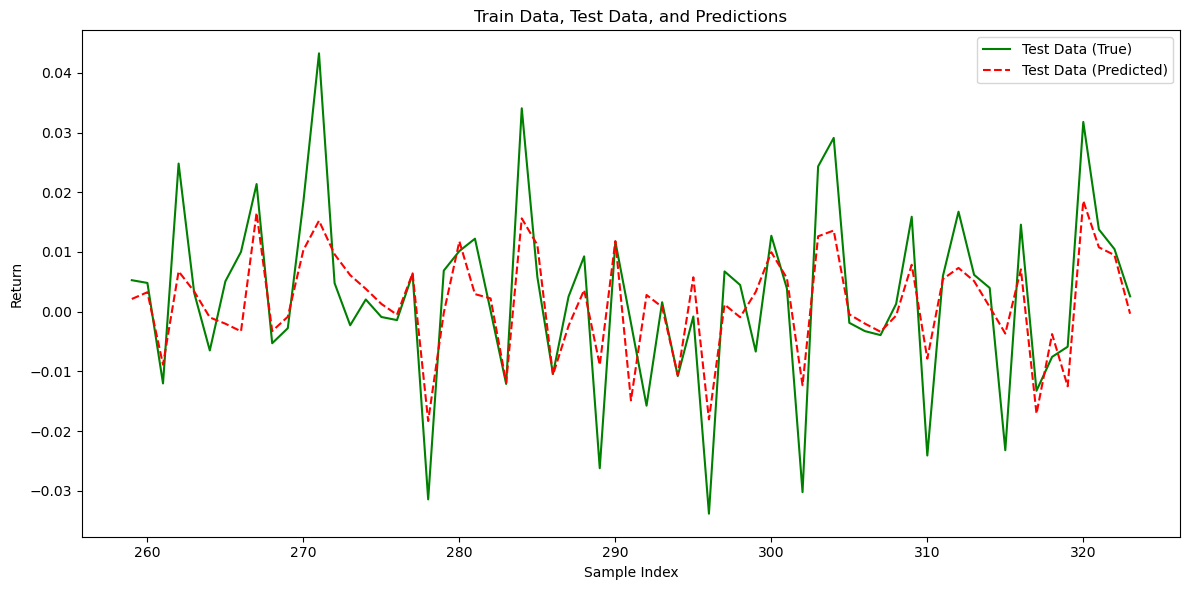

In [159]:
import numpy as np
import matplotlib.pyplot as plt


# Indices for plotting
train_idx = range(len(y_train))
test_idx = range(len(y_train), len(y_train) + len(y_test))

plt.figure(figsize=(12, 6))

# Plot true values for train and test
# plt.plot(train_idx, y_train, label='Train Data (True)', color='blue')
plt.plot(test_idx, y_test, label='Test Data (True)', color='green')

# Plot predictions for test set
plt.plot(test_idx, y_pred, label='Test Data (Predicted)', color='red', linestyle='--')

plt.xlabel('Sample Index')
plt.ylabel('Return')
plt.title('Train Data, Test Data, and Predictions')
plt.legend()
plt.tight_layout()
plt.show()


In [166]:
diff = y_pred - y_test

In [167]:
df_diff = pd.DataFrame(diff)

In [168]:
df_diff['round'] = df_diff['Return'].round(3)

In [169]:
df_plot = df_diff['round'].value_counts().sort_index()

Text(0.5, 1.0, 'Distribution of Return Differences')

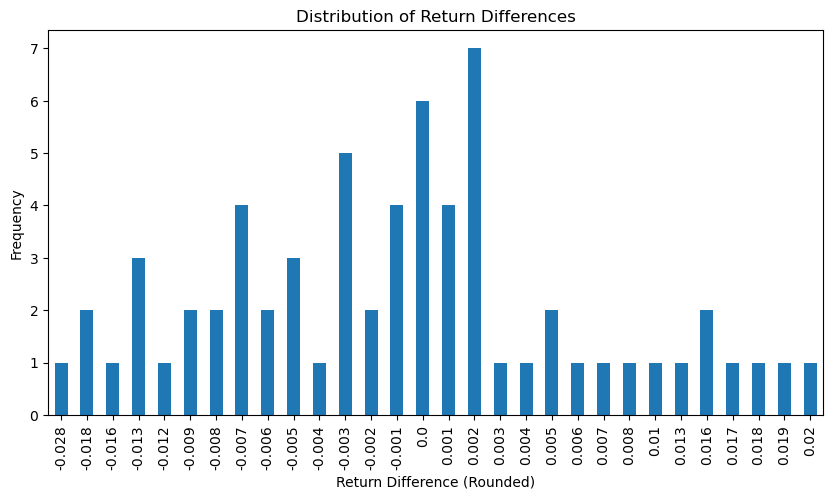

In [170]:
df_plot.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Return Difference (Rounded)')   
plt.ylabel('Frequency')
plt.title('Distribution of Return Differences')

In [174]:
# 7. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# 8. (Optional) Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt']
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

# 9. Feature importance
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=df_X.columns)
sorted_importance = feature_importance.sort_values(ascending=False)

print(sorted_importance.head(20))
# for name, importance in zip(df_X.columns, importances):
#     print(f"{name}: {importance:.3f}")


Root Mean Squared Error: 0.009
R^2 Score: 0.632
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
WILLR_5                0.438684
return_lag1            0.075922
SlowK_None             0.055889
return_lag3            0.043705
SlowD_None             0.028872
return_lag2            0.026953
RSI_5                  0.026712
sentiment_lag5         0.016312
MACD_Hist_None         0.015124
sentiment_score        0.013705
sentiment_lag1         0.012922
sentiment_lag2         0.012125
MACD_None              0.011825
RSI_100                0.011330
return_lag10           0.010417
Real Upper Band_100    0.010361
sentiment_lag20        0.009722
WILLR_10               0.009439
RSI_200                0.008770
sentiment_lag3         0.008703
dtype: float64
